In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvx_portfolio as cp

plotdir = '../portfolio/plots/'

sigmas=pd.read_csv('sigmas.csv.gz',index_col=0,parse_dates=[0])
returns=pd.read_csv('returns.csv.gz',index_col=0,parse_dates=[0])
volumes=pd.read_csv('volumes.csv.gz',index_col=0,parse_dates=[0])

a = pd.DataFrame(data=2.5*1e-4, index=volumes.index, columns=volumes.columns)
b = pd.DataFrame(data=1, index=volumes.index, columns=volumes.columns) # fix volatility model
s = pd.DataFrame(data=1*1e-4, index=volumes.index, columns=volumes.columns)

w_b = pd.Series(index=returns.columns, data=0.)
w_b.USDOLLAR = 1.

p_0 = pd.Series(index=returns.columns, data=1)
p_0.USDOLLAR = 0.
p_0/=sum(p_0)
p_0*=1E8

start_t="2016-12-01"
end_t="2016-12-31"

np.random.seed(0)
noise=pd.DataFrame(index=returns.index, columns=returns.columns, 
                   data=0.1*np.random.randn(*returns.values.shape))
return_estimate= returns + noise
return_estimate.USDOLLAR = returns.USDOLLAR

simulated_tcost = cp.TcostModel(volumes, sigmas, a, b, cash_key='USDOLLAR')
simulated_hcost = cp.HcostModel(s, cash_key='USDOLLAR')
simulator = cp.MarketSimulator(returns, volumes, [simulated_tcost, simulated_hcost], cash_key='USDOLLAR')

from cvx_portfolio.data import series_factor_model_covariance
exposures_pan, factor_sigma_pan, idyos_df = series_factor_model_covariance(returns, variance_explained=.75,
                                                                           freq='MS',lookback_periods = 12)
risk_model = cp.FactorModelSigma(exposures_pan, factor_sigma_pan, idyos_df)

### Proportional 

In [2]:
policy_fixed_trade = cp.ProportionalTrade(targetweight=w_b, 
                        time_steps=returns.index[(returns.index>='2016-12-01')&(returns.index<='2016-12-31')])

result_proportional=\
    simulator.run_backtest(p_0, start_time ='2016-12-01', end_time='2016-12-31', policy=policy_fixed_trade)

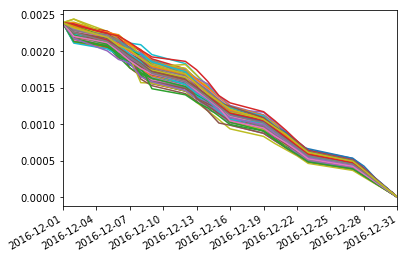

In [3]:
result_proportional.w.ix[:,:-1].plot(legend=False)

## Fixed

In [4]:
# T=len(returns[(returns.index>='2012-12-01')&(returns.index<='2012-12-31')])
# z_target = -(p_0/(T+2))[:-1]
# z_target['USDOLLAR']=-sum(z_target)
# policy_fixed_trade = FixedTrade(tradevec=z_target)

In [5]:
# def concat_results(first, second):
#     first.h_next =  pd.concat([first.h_next, second.h_next])
#     first.u =  pd.concat([first.u,second.u])
#     first.simulator_TcostModel = pd.concat([first.simulator_TcostModel,
#                                                 second.simulator_TcostModel])
#     return first

In [6]:
# day_before = '2016-12-29'
# results_fixed_first=simulator.run_backtest(p_0, start_time = '2016-12-01', end_time='2016-12-29', 
#                                               policy=policy_fixed_trade)
# results_fixed_second = simulator.run_backtest(results_fixed_first.h.ix[-1], 
#                                               start_time = '2016-12-30', end_time='2016-12-31', 
#                                               policy=SellAll())

# results_fixed = concat_results(results_fixed_first, results_fixed_second)

# results_fixed.w.ix[:,:-1].plot(legend=False)

### SPO 

In [7]:
# # larger than .4 we almost don't trade.
# gamma_tcost = 50.
# gamma_risk = 100.
# policy_spo=SinglePeriodOpt(alpha_model, [gamma_risk*risk_model, gamma_tcost*simulated_tcost], [LeverageLimit(3)])

In [8]:
# day_before = '2016-12-29'
# results_spo_first=simulator.run_backtest(p_0, start_time = '2016-12-01', end_time='2016-12-29', 
#                                               policy=policy_spo)
# results_spo_second = simulator.run_backtest(results_spo_first.h.ix[-1], start_time = '2016-12-30', end_time='2016-12-31', 
#                                               policy=SellAll())

# results_spo = concat_results(results_spo_first, results_spo_second)

# results_spo.w.ix[:,:-1].plot(legend=False)
# plt.figure()
# results_spo.simulator_TcostModel.sum(1).plot()

### Define MPO policy 

DEBUG:root:test
INFO:root:Backtest started, from 2016-12-01 00:00:00 to 2016-12-30 00:00:00
INFO:root:Getting trades at time 2016-12-01 00:00:00
INFO:root:Propagating portfolio at time 2016-12-01 00:00:00
INFO:root:Getting trades at time 2016-12-02 00:00:00
INFO:root:Propagating portfolio at time 2016-12-02 00:00:00
INFO:root:Getting trades at time 2016-12-05 00:00:00
INFO:root:Propagating portfolio at time 2016-12-05 00:00:00
INFO:root:Getting trades at time 2016-12-06 00:00:00
INFO:root:Propagating portfolio at time 2016-12-06 00:00:00
INFO:root:Getting trades at time 2016-12-07 00:00:00
INFO:root:Propagating portfolio at time 2016-12-07 00:00:00
INFO:root:Getting trades at time 2016-12-08 00:00:00
INFO:root:Propagating portfolio at time 2016-12-08 00:00:00
INFO:root:Getting trades at time 2016-12-09 00:00:00
INFO:root:Propagating portfolio at time 2016-12-09 00:00:00
INFO:root:Getting trades at time 2016-12-12 00:00:00
INFO:root:Propagating portfolio at time 2016-12-12 00:00:00
INFO

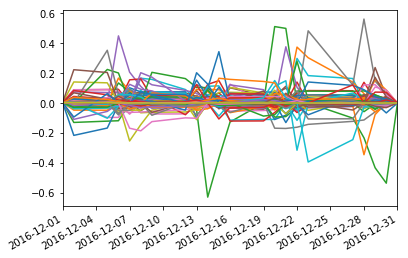

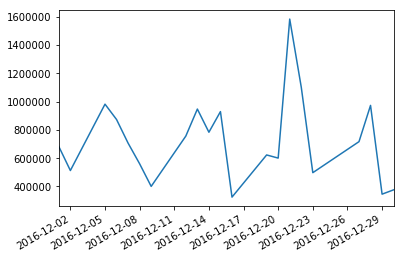

In [9]:
import cvxpy as cvx


gamma_tcost = 100.
gamma_risk = 100.

alpha_model = cp.AlphaSource(return_estimate, gamma_decay=np.inf)

policy_mpo=cp.MultiPeriodOpt(alpha_model=alpha_model, 
                          costs=[gamma_risk*risk_model, gamma_tcost*simulated_tcost], 
                          constraints=[cp.LeverageLimit(3)],
                          trading_times=list(returns.index[-21:]),
                         lookahead_periods=25,
                         terminal_weights=w_b,
                           solver=cvx.SCS)

import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logging.debug("test")

results_mpo = simulator.run_backtest(p_0, start_time = '2016-12-01', end_time='2016-12-31', 
                                              policy=policy_mpo,
                                    loglevel=logging.INFO)

results_mpo.w.ix[:,:-1].plot(legend=False)
plt.figure()
results_mpo.simulator_TcostModel.sum(1).plot()

In [13]:
row_table=lambda x: {r'$\bar R^\mathrm{p}$':"%.2f%%"%(100*x.mean_return), 
           r'$ \sigma^\mathrm{p}$':"%.2f%%"%(100*x.volatility), 
           'Total t. cost': "%.2f$M"%(x.simulator_TcostModel.sum(1).sum()/1000000)}

results=pd.DataFrame(columns=['$\\bar R^\\mathrm{p}$', '$ \\sigma^\\mathrm{p}$', 'Total t. cost'])
results.loc['Fixed trades',] = pd.Series(row_table(result_proportional))
#results.loc['Single period opt.',] = pd.Series(row_table(results_spo))
results.loc['Multi period opt.',] = pd.Series(row_table(results_mpo))
results

,$\bar R^\mathrm{p}$,$ \sigma^\mathrm{p}$,Total t. cost
Fixed trades,21.81%,5.23%,0.03$M
Multi period opt.,-16.94%,14.29%,9.92$M


In [13]:
print(results.to_latex(escape=False).replace('%','\%'))

\begin{tabular}{llll}
\toprule
{} & $\bar R^\mathrm{p}$ & $ \sigma^\mathrm{p}$ & Total t. cost \\
\midrule
Fixed trades       &              17.89\% &                5.17\% &       20.98$M \\
Single period opt. &              10.41\% &                8.37\% &       70.38$M \\
Multi period opt.  &              15.23\% &                4.29\% &       25.41$M \\
\bottomrule
\end{tabular}



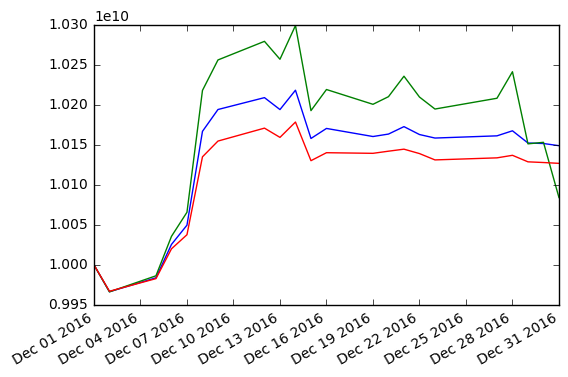

In [16]:
results_fixed.v.plot()
results_spo.v.plot()
results_mpo.v.plot()

### Plot 

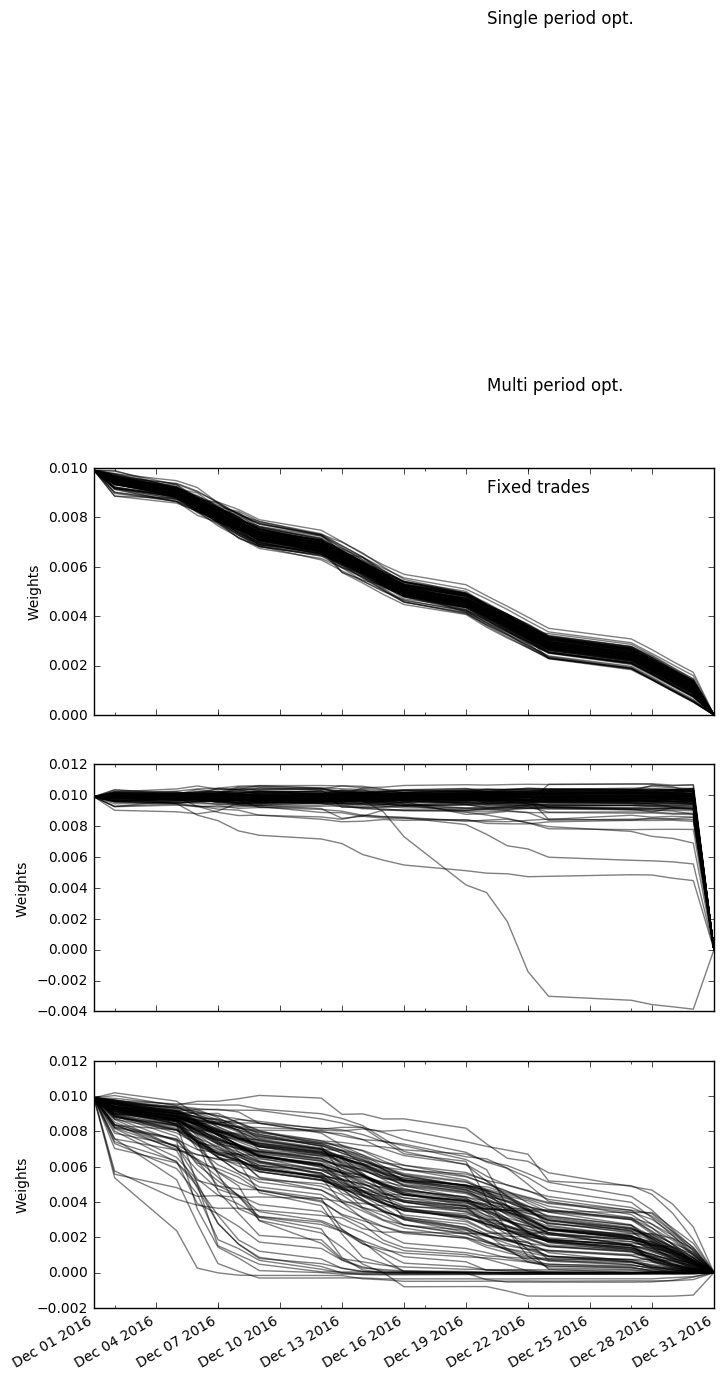

In [15]:
f, axarr = plt.subplots(3, figsize=(8,12),sharex=True)
results_fixed.w.ix[:,:-1].plot(ax=axarr[0], legend=False, style='k-', alpha=0.5)
results_spo.w.ix[:,:-1].plot(ax=axarr[1], legend=False, style='k-', alpha=0.5)
results_mpo.w.ix[:,:-1].plot(ax=axarr[2], legend=False, style='k-', alpha=0.5)
axarr[0].set_ylabel('Weights')
axarr[1].set_ylabel('Weights')
axarr[2].set_ylabel('Weights')
axarr[0].text('2016-12-20',0.009, 'Fixed trades',fontsize=12)
axarr[1].text('2016-12-20',0.06, 'Single period opt.',fontsize=12)
axarr[2].text('2016-12-20',0.05, 'Multi period opt.',fontsize=12)
plt.savefig(plotdir+'mpo-weights.png')